In [1]:
import torch
import torch.utils.checkpoint
from lvdm.models.samplers.ddim import DDIMSampler
import random
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning import seed_everything
seed_everything(42)

from omegaconf import OmegaConf
from einops import rearrange
from pytorch_lightning import seed_everything
from scripts.evaluation.initializer import *
from utils.utils import instantiate_from_config
from scripts.evaluation.funcs import load_model_checkpoint, load_prompts, load_image_batch, get_filelist, save_videos

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt_path = "/home/lee_li/axton_workspace/t2v_newbet/SG-I2V/checkpoints/base_512_v2/model.ckpt"
config = "/home/lee_li/axton_workspace/t2v_newbet/SG-I2V/configs/inference_t2v_512_v2.0.yaml"
config = OmegaConf.load(config)
model_config = config.pop("model", OmegaConf.create())
model = instantiate_from_config(model_config)
model = model.to(device)
model = load_model_checkpoint(model, ckpt_path)
model.eval()
sampler = DDIMSampler(model)


/home/lee_li/miniconda3/envs/t2v/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


AE working on z of shape (1, 4, 64, 64) = 16384 dimensions.


/home/lee_li/miniconda3/envs/t2v/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


>>> model checkpoint loaded.


In [2]:
def hook_downsample_blocks(model, pattern="input_blocks", verbose=True):
    hooks = []

    def hook_fn(name):
        def fn(module, input, output):
            in_shapes = [i.shape if isinstance(i, torch.Tensor) else type(i) for i in input]
            if isinstance(output, torch.Tensor):
                out_shape = output.shape
            elif isinstance(output, (list, tuple)):
                out_shape = [o.shape if isinstance(o, torch.Tensor) else type(o) for o in output]
            else:
                out_shape = type(output)

            if verbose:
                print(f"[{name}] Input: {in_shapes} → Output: {out_shape}")
        return fn

    for name, module in model.named_modules():
        if pattern in name: # and name.endswith(".0"):
            hooks.append(module.register_forward_hook(hook_fn(name)))
    
    return hooks

# hooks = hook_downsample_blocks(model.model)

In [3]:
# # print out model's all layers
# for name, module in model.named_modules():
#     print(name)


In [21]:
agent = initializer(model, sampler)

# prompt = [["A squirrel jumping from one tree to another."]]
prompt = [["cat"]]

latent_shape = [1, 4, 16, 40, 64]

img = torch.randn(latent_shape).to(device)

attn_maps = agent.get_attn(prompt, img, scale=1.0, steps=50)


DDIM scale True
[DEBUG]Conditioning textual context shape: torch.Size([1, 77, 1024])
[DEBUG] sim shape: torch.Size([80, 2560, 77])
[DEBUG] attn shape: torch.Size([80, 2560, 77])
[DEBUG] Height: 40, Width: 64
[DEBUG] sim shape: torch.Size([80, 2560, 77])
[DEBUG] attn shape: torch.Size([80, 2560, 77])
[DEBUG] Height: 40, Width: 64
[DEBUG] sim shape: torch.Size([160, 640, 77])
[DEBUG] attn shape: torch.Size([160, 640, 77])
[DEBUG] Height: 20, Width: 32
[DEBUG] sim shape: torch.Size([160, 640, 77])
[DEBUG] attn shape: torch.Size([160, 640, 77])
[DEBUG] Height: 20, Width: 32
[DEBUG] sim shape: torch.Size([320, 160, 77])
[DEBUG] attn shape: torch.Size([320, 160, 77])
[DEBUG] Height: 10, Width: 16
[DEBUG] sim shape: torch.Size([320, 160, 77])
[DEBUG] attn shape: torch.Size([320, 160, 77])
[DEBUG] Height: 10, Width: 16
[DEBUG] sim shape: torch.Size([320, 40, 77])
[DEBUG] attn shape: torch.Size([320, 40, 77])
[DEBUG] Height: 5, Width: 8
[DEBUG] sim shape: torch.Size([320, 160, 77])
[DEBUG] attn

In [22]:
from transformers import CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text = prompt[0][0]
token_ids = tokenizer.encode(text)  # returns [49406, ..., 49407]
print(token_ids)

# A squirrel jumping from one tree to another.

# 第一个是 [CLS]（id=49406）
# 最后是 [EOS]（id=49407）

[49406, 320, 14004, 11476, 633, 637, 2677, 531, 1380, 269, 49407]


torch.Size([10, 16])


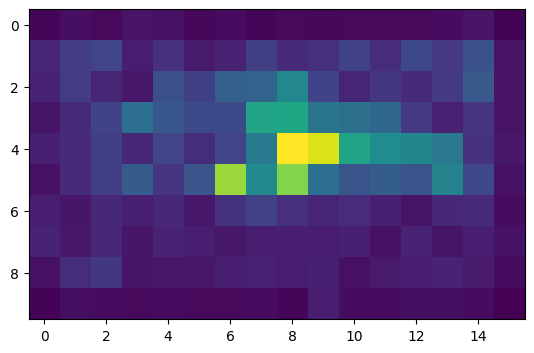

In [27]:
attn_maps[0].shape

tmp_attn_map = attn_maps[0][0]

# should be the first frame
tmp_attn_map.shape

# then get the 3rd token, "squirrel"'s attention heatmap on this frame (0th frame)
token_idx = 2

# get the 3rd tensor from the [10, 16, 40] tensor
this_attn_map = tmp_attn_map[:,:,token_idx]
print(this_attn_map.shape)

# try to visualize the attention map
import matplotlib.pyplot as plt

plt.imshow(this_attn_map)
plt.show()



In [7]:
# average the attn map over the 3rd dimension
